In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 3

# 3.1

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

fashion_test = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)



train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=64, shuffle=False)
fashion_loader = DataLoader(fashion_test, batch_size=64, shuffle=False)

print(f"Train subset size: {len(mnist_train)}, Test size: {len(mnist_test)}")


100%|██████████| 9.91M/9.91M [00:00<00:00, 51.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.68MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 15.2MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.27MB/s]
100%|██████████| 26.4M/26.4M [00:01<00:00, 17.7MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 303kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.57MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 6.73MB/s]

Train subset size: 60000, Test size: 10000


In [4]:

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 30)
        self.fc2 = nn.Linear(30, 20)
        self.fc3 = nn.Linear(20, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

mlp = MLP().to(device)
print(mlp)


MLP(
  (fc1): Linear(in_features=784, out_features=30, bias=True)
  (fc2): Linear(in_features=30, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=10, bias=True)
)


In [5]:

optimizer = optim.Adam(mlp.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

epochs = 10
for epoch in range(epochs):
    mlp.train()
    total_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = mlp(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")


Epoch 1/10, Loss: 0.5533
Epoch 2/10, Loss: 0.3042
Epoch 3/10, Loss: 0.2599
Epoch 4/10, Loss: 0.2287
Epoch 5/10, Loss: 0.2071
Epoch 6/10, Loss: 0.1882
Epoch 7/10, Loss: 0.1763
Epoch 8/10, Loss: 0.1642
Epoch 9/10, Loss: 0.1585
Epoch 10/10, Loss: 0.1502


MLP → Accuracy: 0.9552, F1: 0.9547, Time: 2.60s


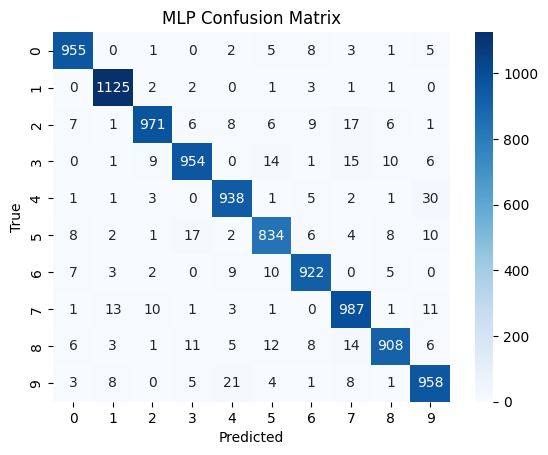

In [6]:

def evaluate(model, loader, name="Model"):
    model.eval()
    y_true, y_pred = [], []
    start = time.time()
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            preds = torch.argmax(out, dim=1)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
    end = time.time()

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"{name} → Accuracy: {acc:.4f}, F1: {f1:.4f}, Time: {end-start:.2f}s")

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    return y_true, y_pred

# Evaluate MLP
y_true_mlp, y_pred_mlp = evaluate(mlp, test_loader, "MLP")


Random Forest:
Accuracy: 0.9668
F1 Score: 0.9665910754853115


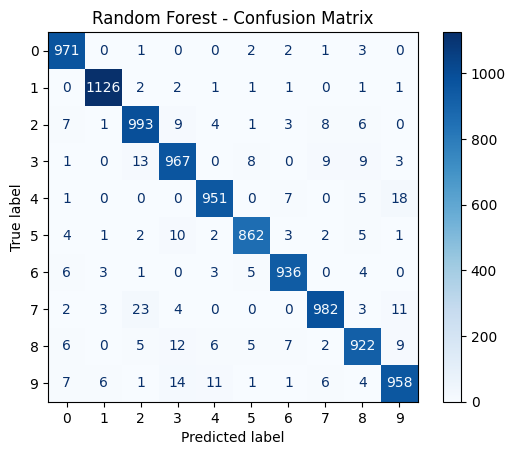


Logistic Regression:
Accuracy: 0.9256
F1 Score: 0.9245145146579435


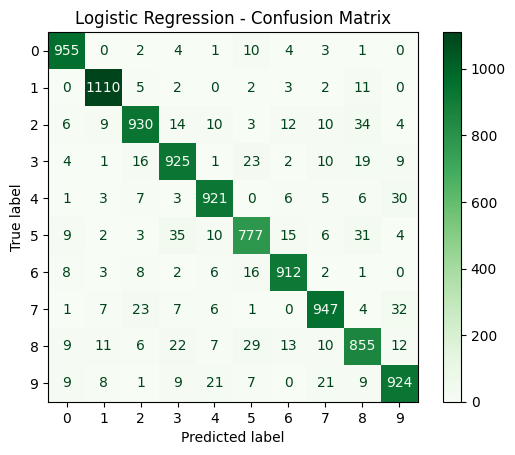

In [7]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Extract flattened features from MNIST
X_train = mnist_train.data.view(-1, 28*28).numpy() / 255.0
y_train = mnist_train.targets.numpy()
X_test = mnist_test.data.view(-1, 28*28).numpy() / 255.0
y_test = mnist_test.targets.numpy()

# Train Random Forest
rf = RandomForestClassifier(n_estimators=50, random_state=42)
rf.fit(X_train, y_train)
y_rf = rf.predict(X_test)

# Train Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_lr = lr.predict(X_test)

# --- Evaluation ---
print("Random Forest:")
print("Accuracy:", accuracy_score(y_test, y_rf))
print("F1 Score:", f1_score(y_test, y_rf, average='macro'))

cm_rf = confusion_matrix(y_test, y_rf)
ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=range(10)).plot(cmap='Blues')
plt.title("Random Forest - Confusion Matrix")
plt.show()

print("\nLogistic Regression:")
print("Accuracy:", accuracy_score(y_test, y_lr))
print("F1 Score:", f1_score(y_test, y_lr, average='macro'))

cm_lr = confusion_matrix(y_test, y_lr)
ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=range(10)).plot(cmap='Greens')
plt.title("Logistic Regression - Confusion Matrix")
plt.show()


Generally MLP  performs better than Logistic Regression and similarly to Random Forest, as MLPs tend to capture more complex patterns in the data.

Our f1-score for random forest is greater than MLP because the ensemble learning methods perform well for simple and structured data liked MNIST dataset.the performance of MLP can be improved by running through more epochs, Increasing the complexity of the MLP (more neurons, layers), Tuning hyperparameters like learning rate and regularization and
Standardizing the input data to optimize training stability.

Logistic Regression might confuse digits that are visually similar (e.g., "3" and "5," "4" and "9") because it lacks hidden layers to capture nuanced(hidden) patterns.

Common Digit Confusions:

From the above confusion matrices, we can expect some common confusions across all models, especially with digits like:

3 and 5: These digits share similar structural features.
5 and 8
4 and 9: Both have circular and angular shapes.
7 and 9

MLP and RF  shows fewer of these confusions, and Logistic Regression  struggle more with such cases.

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.001s...
[t-SNE] Computed neighbors for 10000 samples in 0.633s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.046216
[t-SNE] KL divergence after 250 iterations with early exaggeration: 91.989082
[t-SNE] KL divergence after 1000 iterations: 2.256274
[t-SNE] Computing 91 near

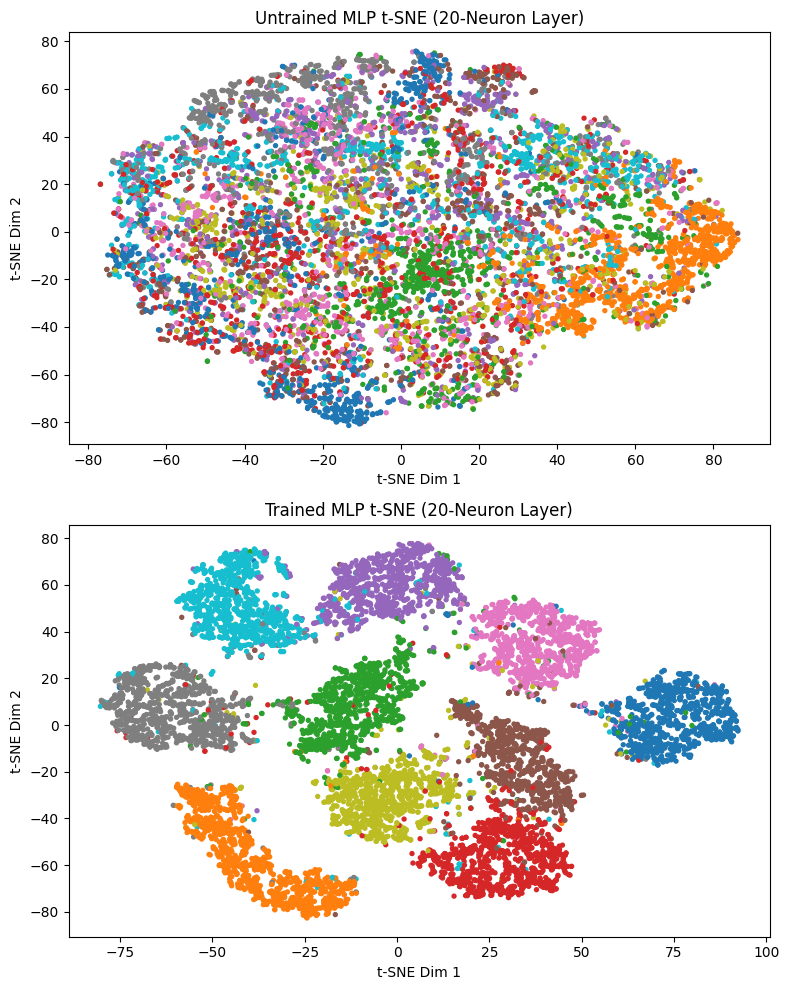

In [8]:
from sklearn.manifold import TSNE
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

def extract_features(model, loader):
    model.eval()
    feats, labels = [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            x = x.view(-1, 28*28)
            h1 = F.relu(model.fc1(x))
            h2 = F.relu(model.fc2(h1))   # 20-neuron layer
            feats.append(h2.cpu().numpy())
            labels.append(y.numpy())
    return np.concatenate(feats), np.concatenate(labels)

# Extract features from trained and untrained models
trained_feats, trained_labels = extract_features(mlp, test_loader)
untrained = MLP().to(device)
untrained_feats, untrained_labels = extract_features(untrained, test_loader)

# t-SNE for both models
tsne_untrained = TSNE(n_components=2, random_state=42, verbose=1)
untrained_tsne = tsne_untrained.fit_transform(untrained_feats)

tsne_trained = TSNE(n_components=2, random_state=42, verbose=1)
trained_tsne = tsne_trained.fit_transform(trained_feats)

# Visualization (stacked vertically)
plt.figure(figsize=(8,10))

# Untrained model (top)
plt.subplot(2,1,1)
plt.scatter(untrained_tsne[:,0], untrained_tsne[:,1], c=untrained_labels, cmap='tab10', s=8)
plt.title("Untrained MLP t-SNE (20-Neuron Layer)")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")

# Trained model (bottom)
plt.subplot(2,1,2)
plt.scatter(trained_tsne[:,0], trained_tsne[:,1], c=trained_labels, cmap='tab10', s=8)
plt.title("Trained MLP t-SNE (20-Neuron Layer)")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")

plt.tight_layout()
plt.show()


Observations from t-SNE Plots:

The trained model's t-SNE plot shows clear separations between digit clusters, with some overlaps   for visually similar digits.

where as,
the untrained model's t-SNE plot  lacks discernible clusters, implying  us how learning from data helps the MLP form meaningful patterns.

MLP on Fashion-MNIST → Accuracy: 0.0682, F1: 0.0540, Time: 2.47s


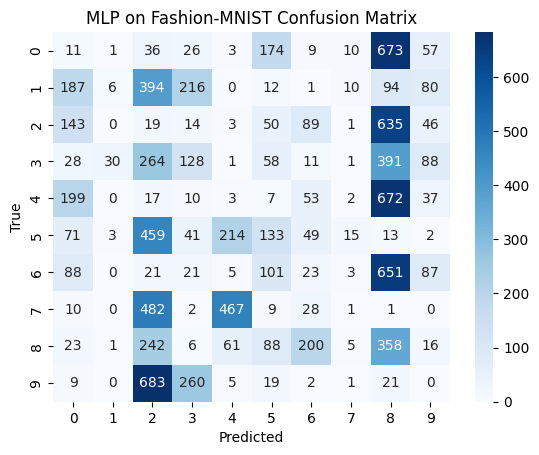

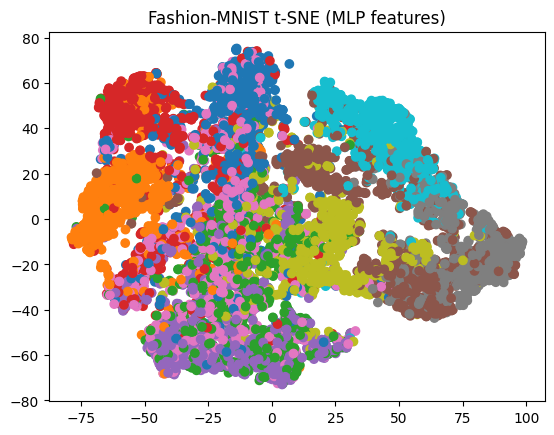

In [9]:

y_true_fashion, y_pred_fashion = evaluate(mlp, fashion_loader, "MLP on Fashion-MNIST")

fashion_feats, fashion_labels = extract_features(mlp, fashion_loader)
tsne_fashion = TSNE(n_components=2, random_state=42).fit_transform(fashion_feats)

plt.scatter(tsne_fashion[:,0], tsne_fashion[:,1], c=fashion_labels, cmap='tab10')
plt.title("Fashion-MNIST t-SNE (MLP features)")
plt.show()

For Fashion-MNIST, the t-SNE embeddings are less distinct due to the complexity of distinguishing clothing categories.

The embeddings for Fashion-MNIST images may show less distinct clustering because the model's second-layer neurons are tuned for digit patterns rather than for clothes.

We might observe some clusters, but they won't be as well-defined as with the MNIST dataset.

Observations:

This comparison highlights the lack of transferability for MLPs when trained on very different datasets. While MLPs can learn meaningful features for specific tasks, these features don't always generalize well to unrelated tasks without further fine-tuning.

## 3.2

In [10]:

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32*14*14, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 32*14*14)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

cnn = SimpleCNN().to(device)
print(cnn)


SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=6272, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [11]:

optimizer = optim.Adam(cnn.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

epochs = 5
for epoch in range(epochs):
    cnn.train()
    total_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = cnn(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")


Epoch 1/5, Loss: 0.1944
Epoch 2/5, Loss: 0.0656
Epoch 3/5, Loss: 0.0469
Epoch 4/5, Loss: 0.0335
Epoch 5/5, Loss: 0.0252


Simple CNN → Accuracy: 0.9817, F1: 0.9816, Time: 3.77s


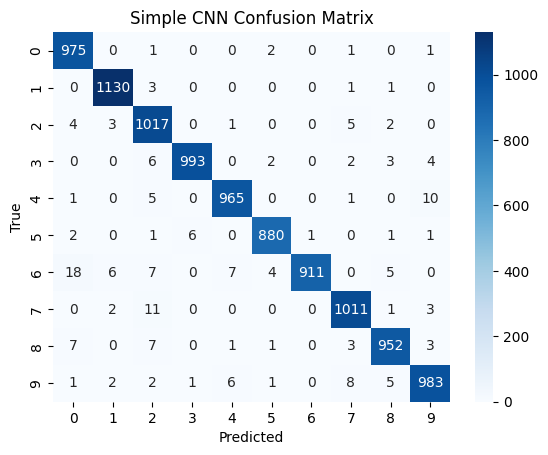

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 93.4MB/s]
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 130MB/s] 



Simple CNN Results:
Accuracy: 0.9817
F1 Score: 0.9816
Inference Time: 4.17s


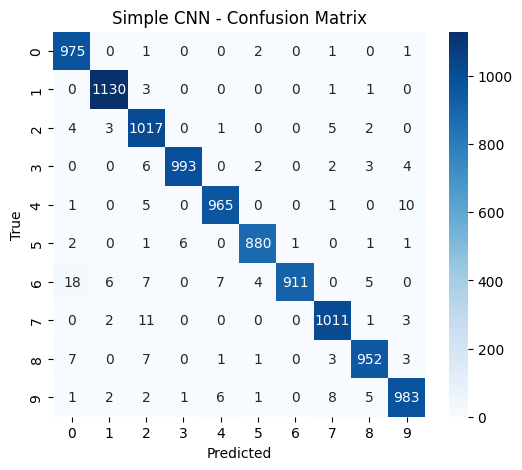


MobileNetV3 Results:
Accuracy: 0.0989
F1 Score: 0.0200
Inference Time: 67.93s


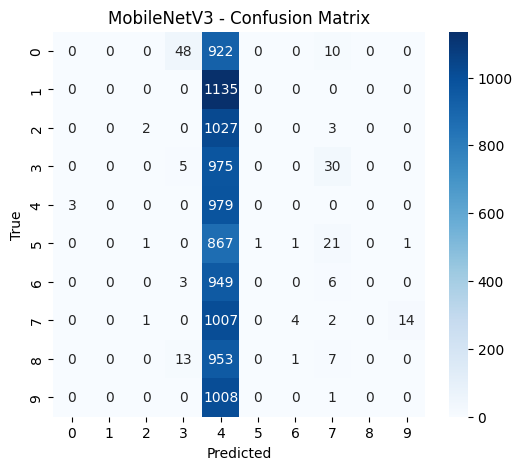


EfficientNet-B0 Results:
Accuracy: 0.0479
F1 Score: 0.0398
Inference Time: 589.62s


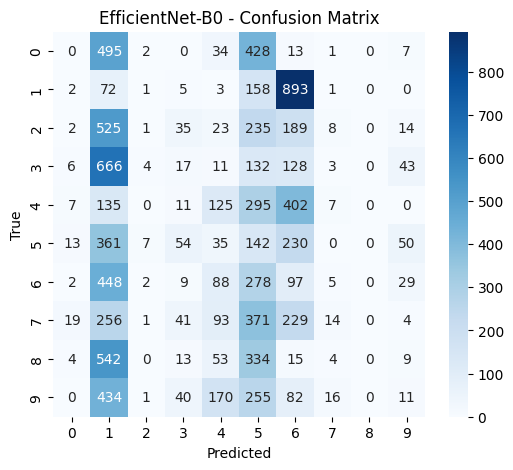

In [12]:
import time
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate custom CNN
start = time.time()
y_true_cnn, y_pred_cnn = evaluate(cnn, test_loader, "Simple CNN")
end = time.time()
cnn_time = end - start

# Load pretrained CNNs (using pretrained weights)
mobilenet = models.mobilenet_v3_small(weights='IMAGENET1K_V1')
mobilenet.classifier[3] = nn.Linear(mobilenet.classifier[3].in_features, 10)
mobilenet = mobilenet.to(device)
mobilenet.eval()

efficientnet = models.efficientnet_b0(weights='IMAGENET1K_V1')
efficientnet.classifier[1] = nn.Linear(efficientnet.classifier[1].in_features, 10)
efficientnet = efficientnet.to(device)
efficientnet.eval()

# Resize MNIST to 3x224x224 for pretrained models
transform_large = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(3),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
mnist_large = datasets.MNIST(root='./data', train=False, download=True, transform=transform_large)
large_loader = DataLoader(mnist_large, batch_size=32, shuffle=False)

# Evaluate pretrained models with inference time
y_true_pre, y_pred_mobile, y_pred_eff = [], [], []

start = time.time()
with torch.no_grad():
    for x, y in large_loader:
        x, y = x.to(device), y.to(device)
        y_true_pre.extend(y.cpu().numpy())
        y_pred_mobile.extend(torch.argmax(mobilenet(x), dim=1).cpu().numpy())
end = time.time()
mobile_time = end - start

start = time.time()
with torch.no_grad():
    for x, y in large_loader:
        x, y = x.to(device), y.to(device)
        y_pred_eff.extend(torch.argmax(efficientnet(x), dim=1).cpu().numpy())
end = time.time()
eff_time = end - start

# Compute and display metrics for all models
def print_metrics(name, y_true, y_pred, infer_time):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='macro')
    print(f"\n{name} Results:")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Inference Time: {infer_time:.2f}s")
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# Print metrics for all three models
print_metrics("Simple CNN", y_true_cnn, y_pred_cnn, cnn_time)
print_metrics("MobileNetV3", y_true_pre, y_pred_mobile, mobile_time)
print_metrics("EfficientNet-B0", y_true_pre, y_pred_eff, eff_time)

In [13]:

def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Model Comparison:")
print(f"MLP params: {count_params(mlp)}")
print(f"CNN params: {count_params(cnn)}")
print(f"MobileNet params: {count_params(mobilenet)}")
print(f"EfficientNet params: {count_params(efficientnet)}")


Model Comparison:
MLP params: 24380
CNN params: 804554
MobileNet params: 1528106
EfficientNet params: 4020358
